# Introduction

The Dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The goal is then to predict which previously purchased products will be in a user’s next order. Now let's jump straight into the data and do some exploratory analysis.

In [1]:
# import the needed librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore') 

pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points

In [2]:
# load all the dataset
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

## Orders and Products

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products_prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [3]:
# check two datasets' frame
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [4]:
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
# Put both of them into a same dataframe
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [9]:
order_products_all.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


### 1. Missing Data

In [10]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
order_id,0,0.000
product_id,0,0.000
add_to_cart_order,0,0.000
reordered,0,0.000


No missing data in this dataset so that we can do our analysis easier.

In [12]:
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


Check out the number of products that people usually order with histogram:

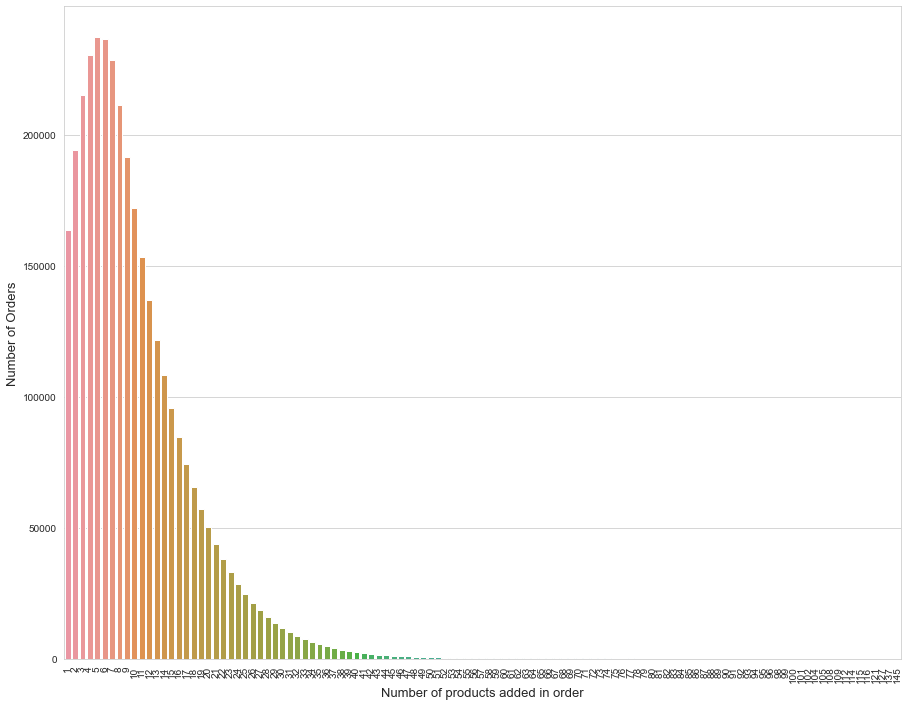

In [13]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

So it looks like people usually order around 5 products.

### 2. Most Ordered Products

In [14]:
grouped = order_products_all.groupby("product_id")['reordered'].count().reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='reordered', ascending=False)[:10]
grouped.columns=['product_id','Total_reorders','product_name']
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Products like banana,strawberry and avocado are ordered most.

In [15]:
grouped = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)
grouped

product_name
Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: Total_reorders, dtype: int64

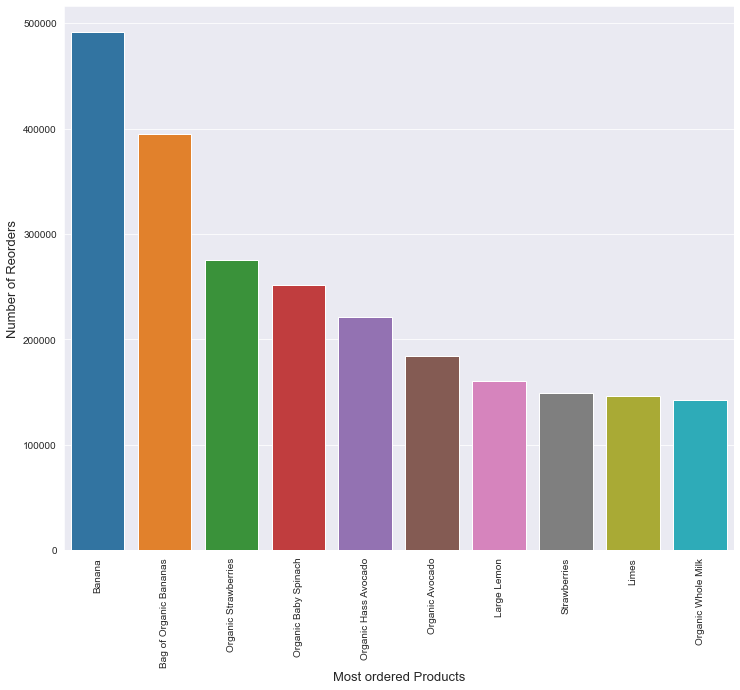

In [16]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

Let's check if people often reorder the same previous ordered products.

In [17]:
grouped = order_products_all.groupby("reordered")["product_id"].count().reset_index()
grouped.columns=['reordered','Total_products']
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


So we can see 59% of ordered products are previously ordered by customers.

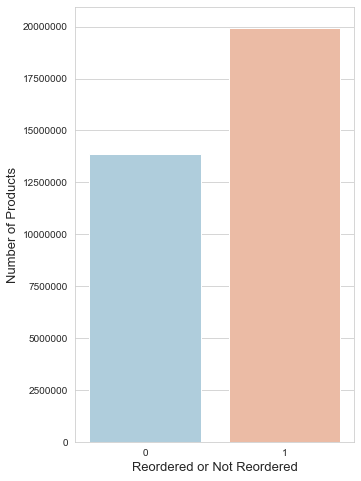

In [18]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### 3. Most Reordered Products 

In [26]:
grouped = order_products_all.groupby("product_id")['reordered'].agg({'sum','count'}).reset_index()
grouped.columns=['product_id','reorder_sum','reorder_total']
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.922,Chocolate Love Bar
35601,35604,93,104,0.894,Maca Buttercups
38248,38251,99,111,0.892,Benchbreak Chardonnay
36798,36801,88,99,0.889,Organic Blueberry B Mega
10233,10236,114,131,0.870,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868,Thousand Island Salad Snax
5455,5457,78,90,0.867,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861,Half And Half Ultra Pasteurized


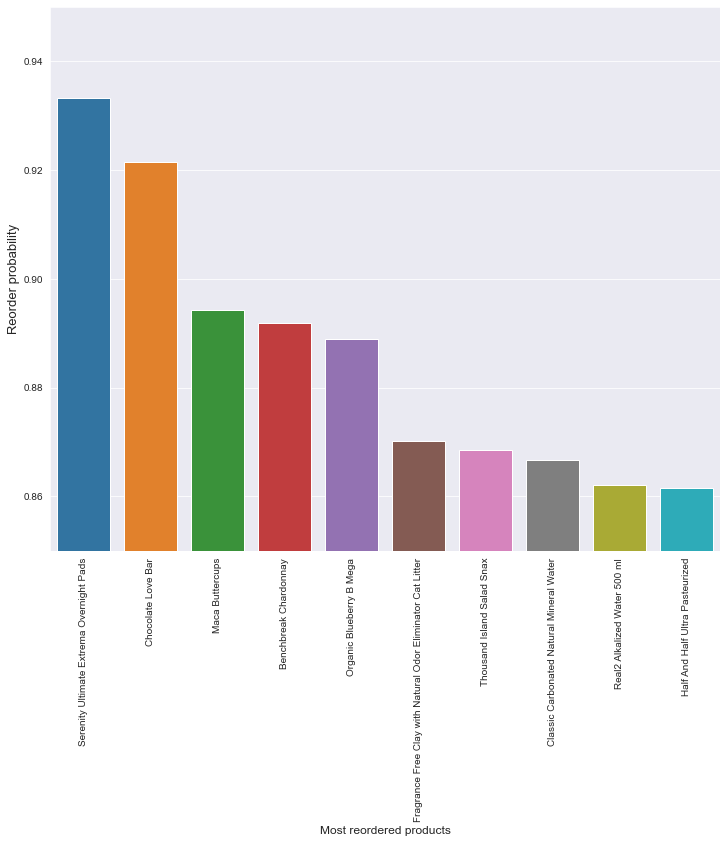

In [27]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

## Orders

In [28]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data are: ", orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data are:  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [29]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


### 1. Missing Data

In [30]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na

order_id                 0.000
user_id                  0.000
eval_set                 0.000
order_number             0.000
order_dow                0.000
order_hour_of_day        0.000
days_since_prior_order   6.028
dtype: float64

### 2. Time of Orders

Hour of orders in a day:

In [31]:
grouped = orders.groupby("order_id")["order_hour_of_day"].sum().reset_index()
grouped = grouped.order_hour_of_day.value_counts()

grouped

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64

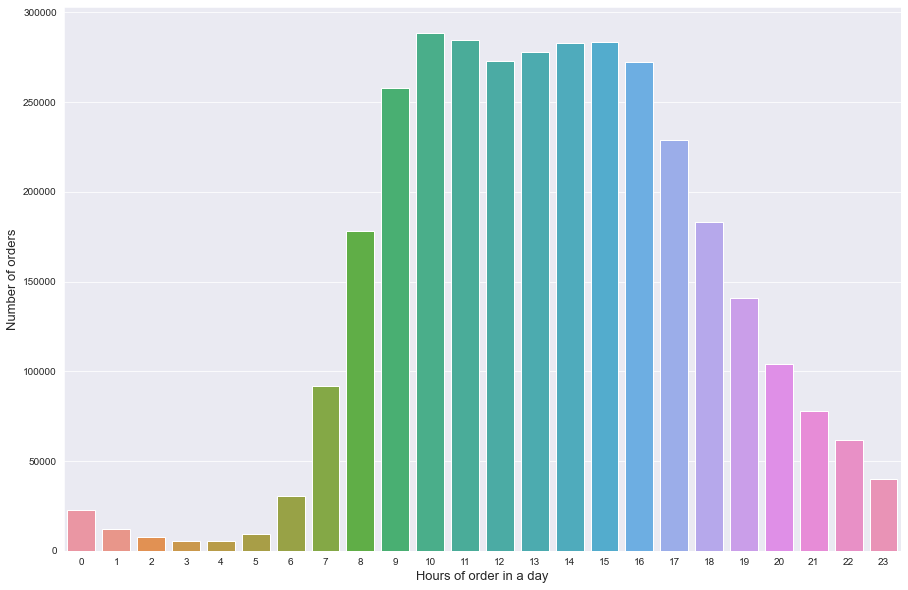

In [32]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

We can see people mostly order between 8 and 19 (anonimyzed hours and probably between 8 a.m and 7 p.m.)

Day of orders in a week:

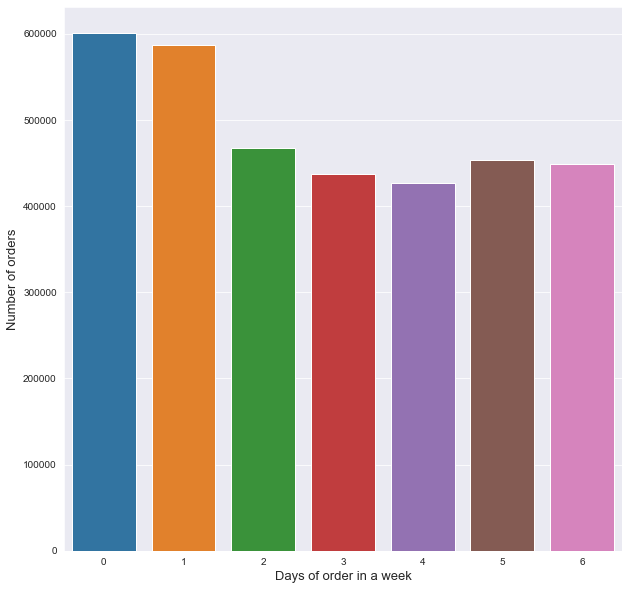

In [34]:
grouped = orders.groupby("order_id")["order_dow"].sum().reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

Customers usually order on weekends.

Time of reorders:

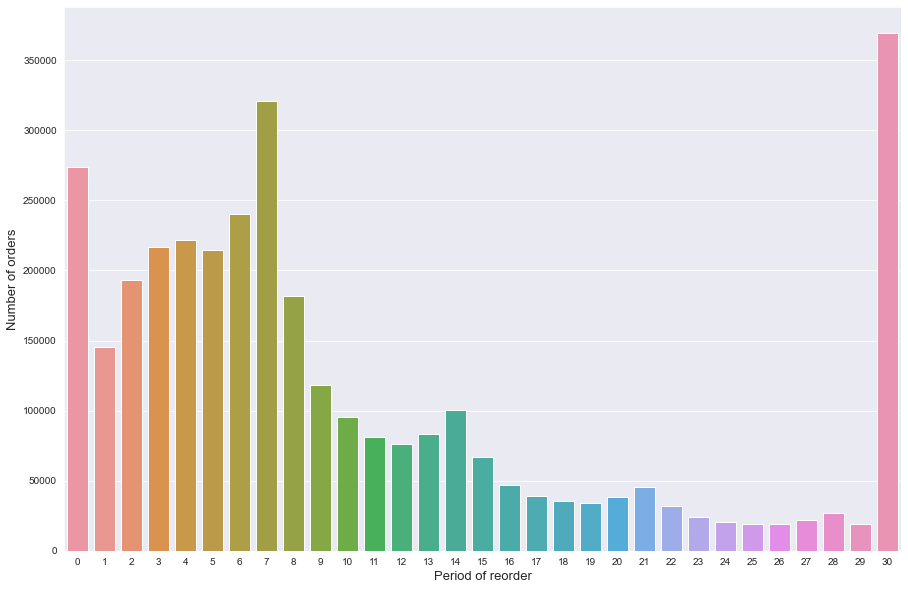

In [35]:
grouped = orders.groupby("order_id")["days_since_prior_order"].sum().reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

### 3. Orders in the whole dataset

In [36]:
grouped = orders.groupby("eval_set")["order_id"].count().reset_index()
grouped.columns=['eval_set','Total_orders']
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.940
1,test,75000,0.022
2,train,131209,0.038


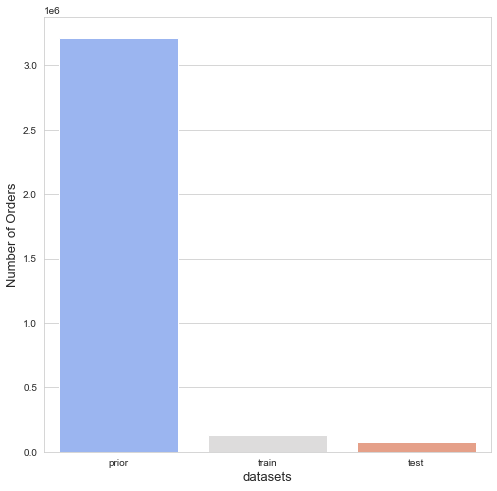

In [37]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

### Customers in the whole dataset

In [38]:
print("Number of unique customers in the whole dataset: ",len(set(orders.user_id)))

Number of unique customers in the whole dataset:  206209


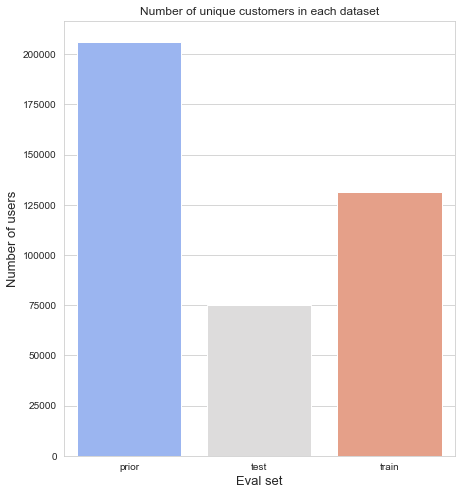

In [39]:
grouped = orders.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))

plt.figure(figsize=(7,8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()

### 4. Orders made by each customer

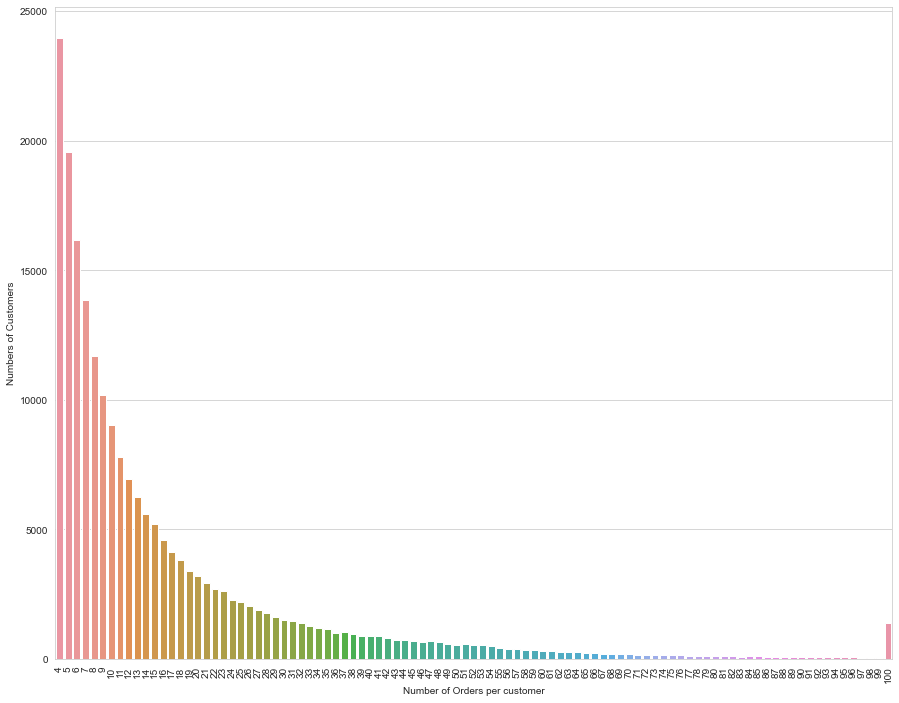

In [40]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

Most customers order 4 items in one purchase.

## Products

In [41]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [42]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [43]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Combine all of them in one dataframe.

In [44]:
items = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


### 1. Most important Departments (by number of products)

In [45]:
grouped = items.groupby("department")["product_id"].agg({'count'}).reset_index()
grouped['Ratio'] = grouped["count"].apply(lambda x: x /grouped['count'].sum())
grouped.sort_values(by='count', ascending=False, inplace=True)
grouped.columns=['department','Total_products','Ratio']
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


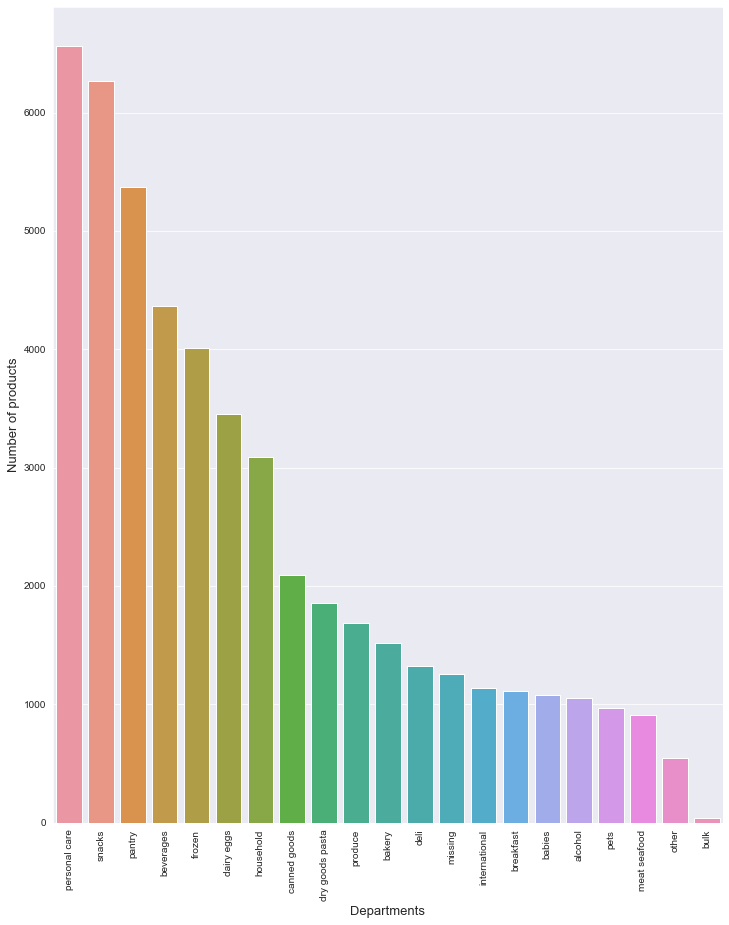

In [46]:
grouped = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

### 2. Most important Aisles in each Department (by number of Products)

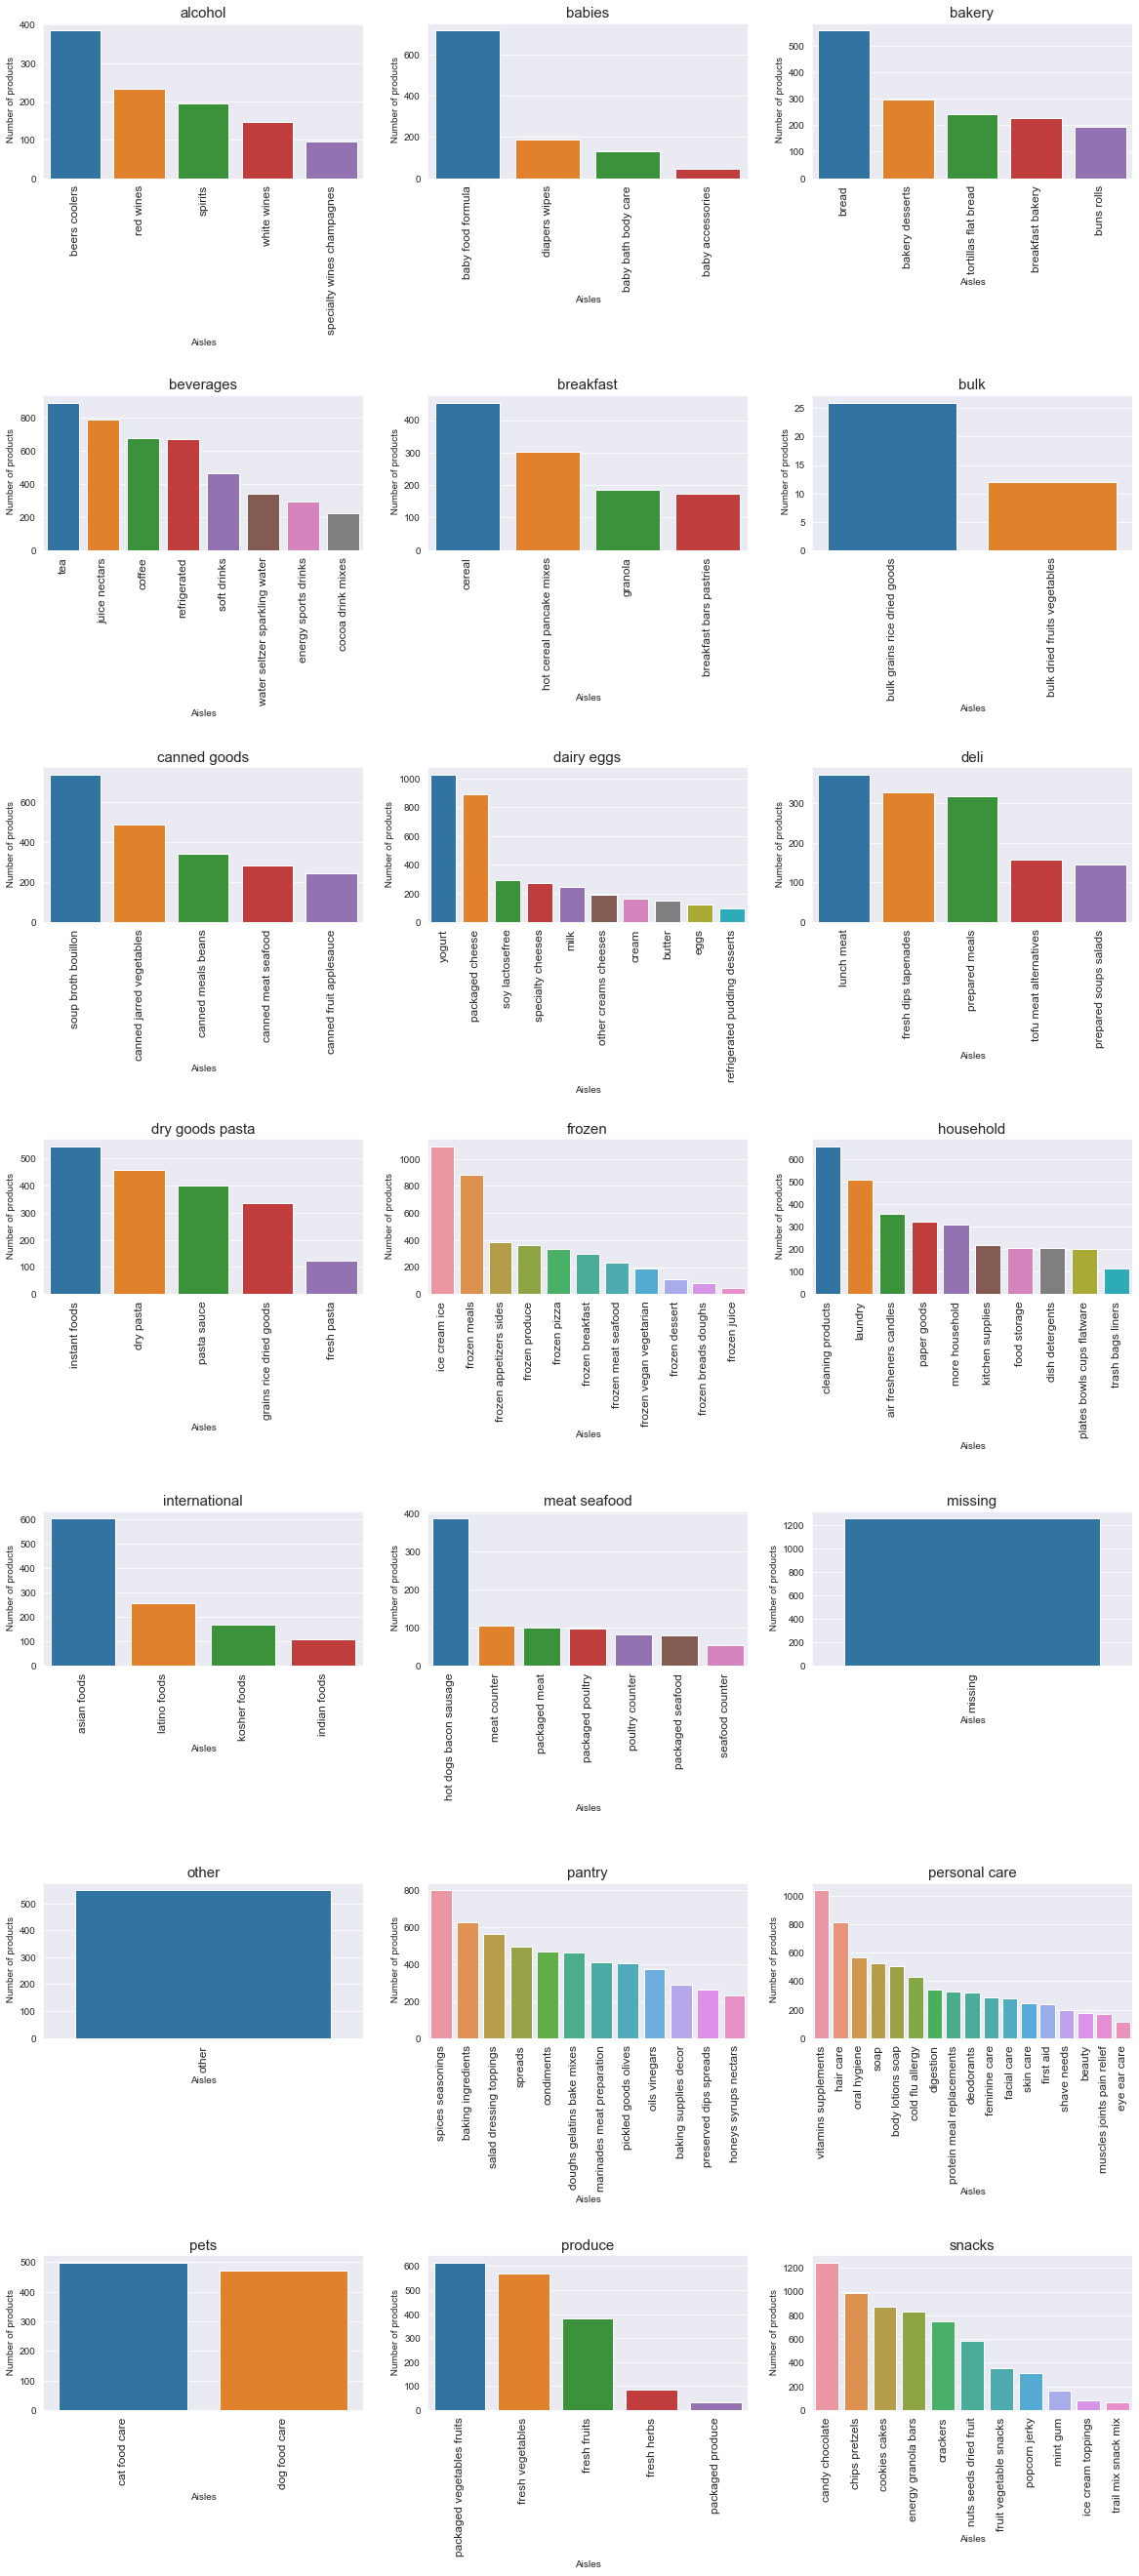

In [47]:
grouped = items.groupby(["department", "aisle"])["product_id"].agg({'count'}).reset_index()
grouped.columns=['department','aisle','Total_products']
grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### 3. Most important Aisles over all Departments (by number of Products)

In [48]:
grouped = items.groupby("aisle")["product_id"].agg({'count'}).reset_index()
grouped.columns=['product_id','Total_products']
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,product_id,Total_products,Ratio
85,missing,1258,0.025
18,candy chocolate,1246,0.025
71,ice cream ice,1091,0.022
130,vitamins supplements,1038,0.021
133,yogurt,1026,0.021
25,chips pretzels,989,0.020
125,tea,894,0.018
93,packaged cheese,891,0.018
59,frozen meals,880,0.018
31,cookies cakes,874,0.018


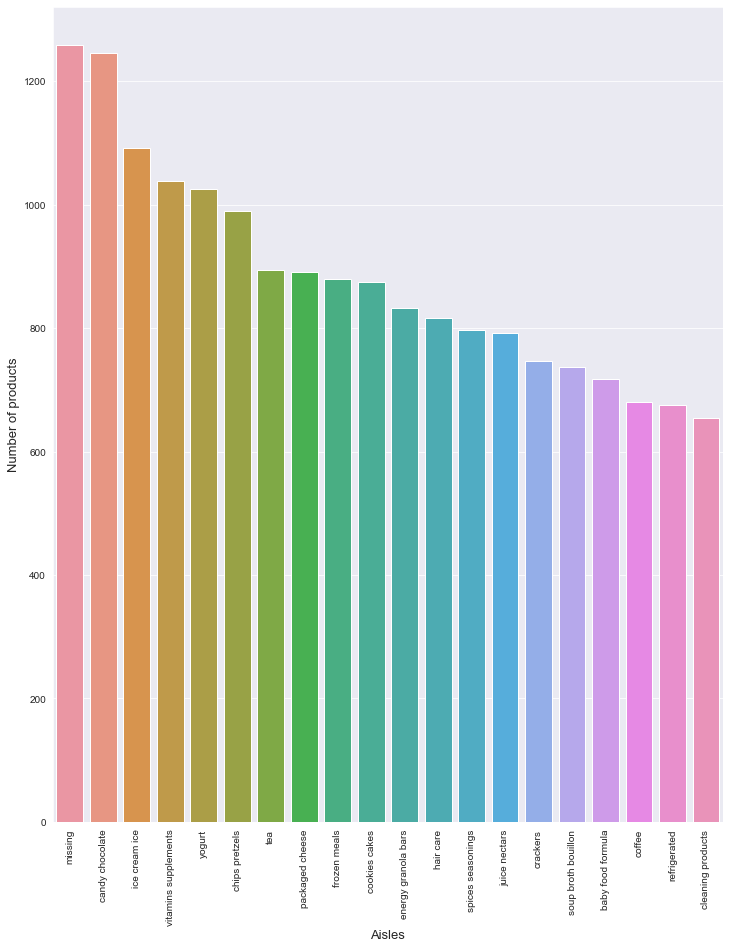

In [49]:
grouped  = grouped.groupby(['product_id']).sum()['Total_products'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()


In [50]:
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')
users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

### 4. Best Selling Departments (number of Orders)

In [54]:
grouped = users_flow.groupby("department")["order_id"].count().reset_index()
grouped.columns=['order_id','Total_orders']
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,order_id,Total_orders,Ratio
19,produce,409087,0.295
7,dairy eggs,217051,0.157
20,snacks,118862,0.086
3,beverages,114046,0.082
10,frozen,100426,0.073
16,pantry,81242,0.059
2,bakery,48394,0.035
6,canned goods,46799,0.034
8,deli,44291,0.032
9,dry goods pasta,38713,0.028


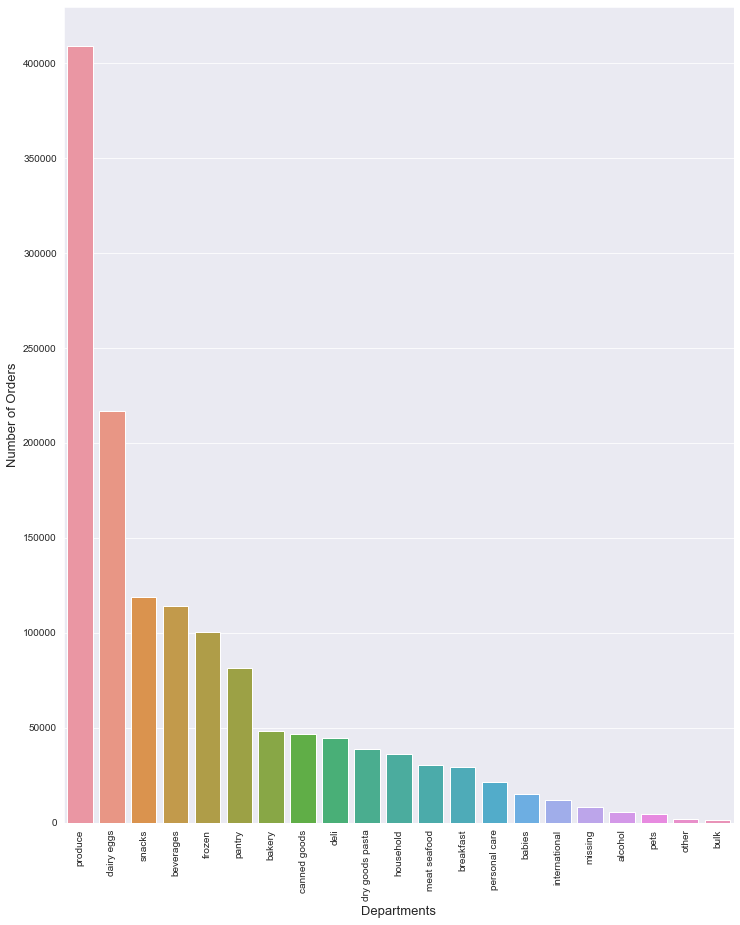

In [55]:
grouped = grouped.groupby(['order_id']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

### 5. Best Selling Aisles in each Department (number of Orders)

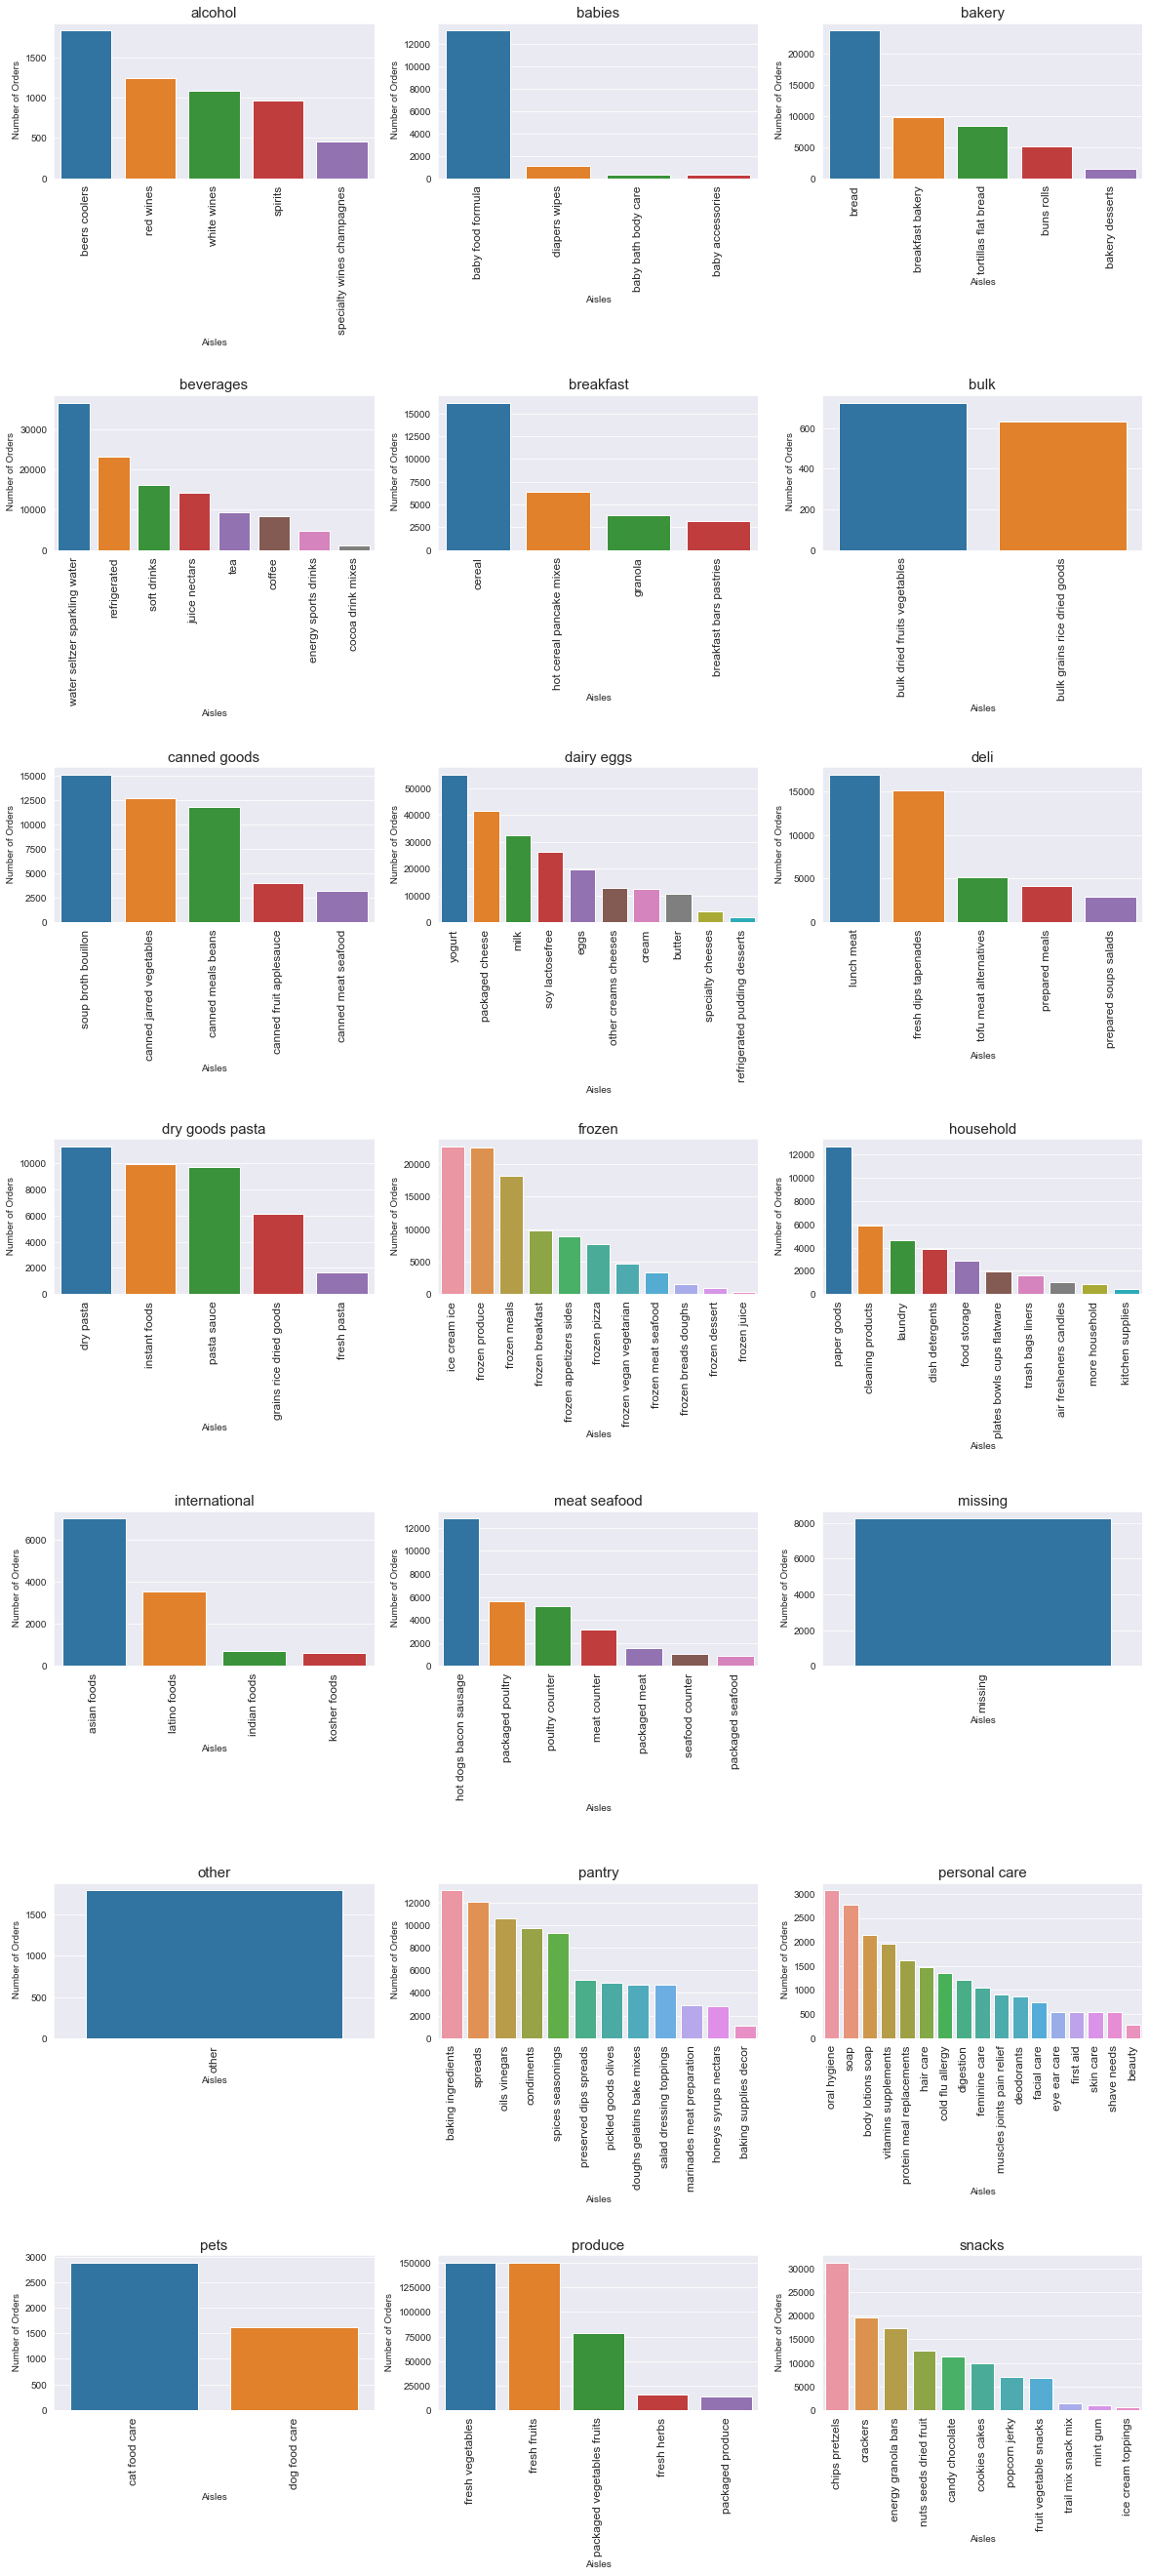

In [56]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].count().reset_index()
grouped.columns=['department','aisle','Total_orders']

grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

### 6. Best Selling Aisles over all Departments

In [57]:
grouped = users_flow.groupby("aisle")["order_id"].count().reset_index()
grouped.columns=['order_id','Total_orders']
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,order_id,Total_orders,Ratio
53,fresh vegetables,150609,0.109
50,fresh fruits,150473,0.109
98,packaged vegetables fruits,78493,0.057
133,yogurt,55240,0.040
93,packaged cheese,41699,0.030
131,water seltzer sparkling water,36617,0.026
83,milk,32644,0.024
25,chips pretzels,31269,0.023
119,soy lactosefree,26240,0.019
11,bread,23635,0.017


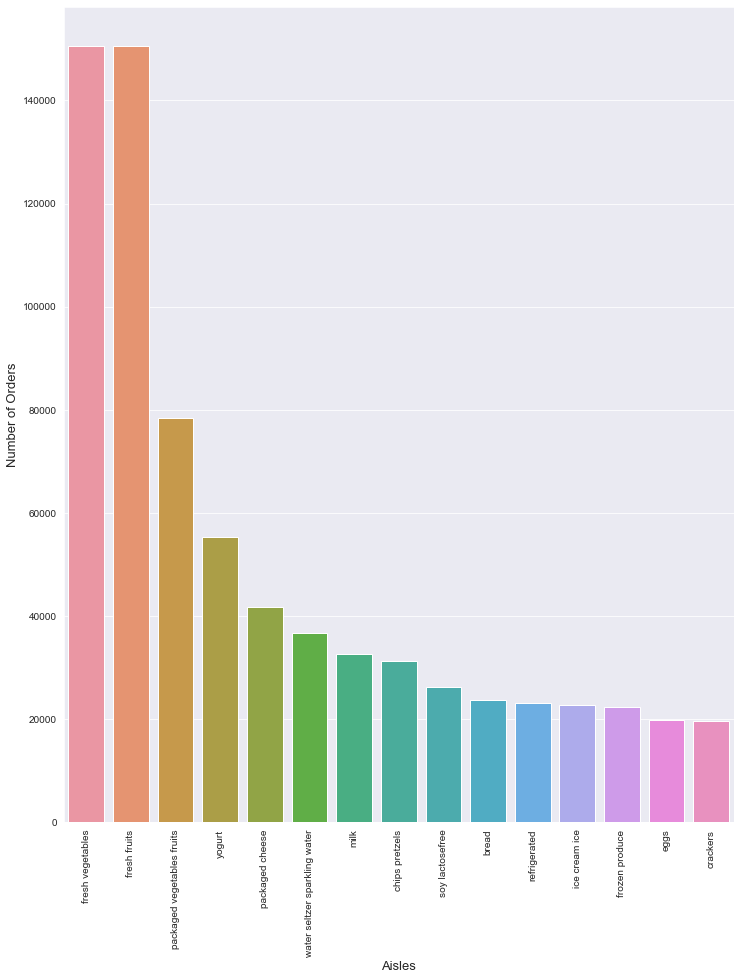

In [58]:
grouped = grouped.groupby(['order_id']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()